***Business Problem:*** A fictional telco company that provided home phone and Internet services to 7043 customers in California in Q3. The dataset indicates which customers have left, stayed, or signed up for their service. Multiple important demographics are included for each customer, as well as a Satisfaction Score, Churn Score, and Customer Lifetime Value (CLTV) index, etc. The company wants to know which cutomers are likely to stop using their services.

**Solution:** Develop a predictive model to predict which customers are likely to churn.

***Data Description***

In this dataset there are 7043 observations with 33 variables. The description of the variables are as follows:-

CustomerID: A unique ID that identifies each customer.

Count: A value used in reporting/dashboarding to sum up the number of customers in a filtered set.

Country: The country of the customer’s primary residence.

State: The state of the customer’s primary residence.

City: The city of the customer’s primary residence.

Zip Code: The zip code of the customer’s primary residence.

Lat Long: The combined latitude and longitude of the customer’s primary residence.

Latitude: The latitude of the customer’s primary residence.

Longitude: The longitude of the customer’s primary residence.

Gender: The customer’s gender: Male, Female

Senior Citizen: Indicates if the customer is 65 or older: Yes, No

Partner: Indicate if the customer has a partner: Yes, No

Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.

Tenure Months: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.

Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No

Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No

Internet Service: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.

Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No

Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No

Device Protection: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No

Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No

Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.

Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.

Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.

Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No

Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check

Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company.

Total Charges: Indicates the customer’s total charges, calculated to the end of the quarter specified above.

Churn Label: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

Churn Value: 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.

Churn Score: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.

CLTV: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.

Churn Reason: A customer’s specific reason for leaving the company. Directly related to Churn Category.

**Dataset source:** https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset

**Solution developed by**: Arjun Baidya (Email: arjun.p.baidya@gmail.com)

In [1]:
# Importing necessary modules

import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer, f1_score, classification_report
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Let's import the dataset into a Pandas dataframe

df = pd.read_excel('Telco_customer_churn.xlsx')
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


The last 3 columns/features and 'Churn Label' contains exit interview information which will not be available during prediction so we should not use them. We will drop these columns.

In [3]:
df.drop(['Churn Label','Churn Score','CLTV','Churn Reason'], axis=1, inplace=True)

### Le's begin EDA

In [4]:
# Let's take a look at the variables in the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

Total_Charges feature is of the type object which is strange so we will inspect it later.

Let's check out the unique values of the features

In [5]:
for col in df.columns:
    print(f"\n{col}:")
    print(df[col].unique())


CustomerID:
['3668-QPYBK' '9237-HQITU' '9305-CDSKC' ... '2234-XADUH' '4801-JZAZL'
 '3186-AJIEK']

Count:
[1]

Country:
['United States']

State:
['California']

City:
['Los Angeles' 'Beverly Hills' 'Huntington Park' ... 'Standish' 'Tulelake'
 'Olympic Valley']

Zip Code:
[90003 90005 90006 ... 96128 96134 96146]

Lat Long:
['33.964131, -118.272783' '34.059281, -118.30742' '34.048013, -118.293953'
 ... '40.346634, -120.386422' '41.813521, -121.492666'
 '39.191797, -120.212401']

Latitude:
[33.964131 34.059281 34.048013 ... 40.346634 41.813521 39.191797]

Longitude:
[-118.272783 -118.30742  -118.293953 ... -120.386422 -121.492666
 -120.212401]

Gender:
['Male' 'Female']

Senior Citizen:
['No' 'Yes']

Partner:
['No' 'Yes']

Dependents:
['No' 'Yes']

Tenure Months:
[ 2  8 28 49 10  1 47 17  5 34 11 15 18  9  7 12 25 68 55 37  3 27 20  4
 58 53 13  6 19 59 16 52 24 32 38 54 43 63 21 69 22 61 60 48 40 23 39 35
 56 65 33 30 45 46 62 70 50 44 71 26 14 41 66 64 29 42 67 51 31 57 36 72
  0]

Ph

Clearly, the features count, country and State have only 1 value in them, therefore, they won't be of any use for modelling. We also do not need 'Customer ID' since it's unique for each customer and 'Lat Long' feature is only a combination of Latitude and Longitude will is already present as seperate columns. We also don't need Zipcode since we already have locational information via Latitude and Longitude columns.

In [6]:
df.drop(['Count','Country','State','Lat Long','Zip Code','CustomerID'], axis=1, inplace=True)

Since we want to draw a tree later on we have to replace the blank spaces in the city names in the City column. We would do it for all the columns so we apply the replacement of blank spaces with undescore dataframe-wide.

In [7]:
df.replace(' ', '_', regex=True, inplace=True)

In [8]:
# Let's check a few city names

df['City'].unique()

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', ..., 'Standish',
       'Tulelake', 'Olympic_Valley'], dtype=object)

We will also replace the white spaces in the column/feature names

In [9]:
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['City', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen', 'Partner',
       'Dependents', 'Tenure_Months', 'Phone_Service', 'Multiple_Lines',
       'Internet_Service', 'Online_Security', 'Online_Backup',
       'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies',
       'Contract', 'Paperless_Billing', 'Payment_Method', 'Monthly_Charges',
       'Total_Charges', 'Churn_Value'],
      dtype='object')

**Handling missing data**

We are going to use XGBOOST later on and we know it has a default behaviour while dealing with missing values. It requires missing values to be set to 0.

In [10]:
# Let's check which variables have missing values in them

df.isnull().sum()

City                 0
Latitude             0
Longitude            0
Gender               0
Senior_Citizen       0
Partner              0
Dependents           0
Tenure_Months        0
Phone_Service        0
Multiple_Lines       0
Internet_Service     0
Online_Security      0
Online_Backup        0
Device_Protection    0
Tech_Support         0
Streaming_TV         0
Streaming_Movies     0
Contract             0
Paperless_Billing    0
Payment_Method       0
Monthly_Charges      0
Total_Charges        0
Churn_Value          0
dtype: int64

There are no missing values but we must also check if there are surrogate values for missing values.

In [11]:
# Let's now inspect the Total_Charges feature a bit

df['Total_Charges'].unique()

array([108.15, 151.65, 820.5, ..., 7362.9, 346.45, 6844.5], dtype=object)

This should be a numeric feature so let's cast it to float type

In [12]:
#df['Total_Charges'].astype('float64')

I have commented out the above statement. However, when I ran it earlier it threw the following error: ***ValueError: could not convert string to float: '_'***

So there are string values '_' in this feature which needs to be sanitized

In [13]:
len(df.loc[df['Total_Charges']=='_'])

11

In [14]:
# So there are 11 such values and we need to set them to 0

df['Total_Charges'].replace('_', 0, inplace=True)

In [15]:
# Re-checking for ' ' values

len(df.loc[df['Total_Charges']=='_'])

0

In [16]:
# Converting Totat_Charges from object to float type

df['Total_Charges'] = df['Total_Charges'].astype('float64')

In [17]:
# Let's recheck the datatype of Totat_Charges

df['Total_Charges'].dtype

dtype('float64')

**Descriptive statistics of the numeric variables**

In [18]:
df.describe()

,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,Churn_Value
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,36.282441,-119.798880,32.371149,64.761692,2279.734304,0.265370
std,2.455723,2.157889,24.559481,30.090047,2266.794470,0.441561
min,32.555828,-124.301372,0.000000,18.250000,0.000000,0.000000
25%,34.030915,-121.815412,9.000000,35.500000,398.550000,0.000000
50%,36.391777,-119.730885,29.000000,70.350000,1394.550000,0.000000
75%,38.224869,-118.043237,55.000000,89.850000,3786.600000,1.000000
max,41.962127,-114.192901,72.000000,118.750000,8684.800000,1.000000


If we look at the Mean and the Standard deviations, then it is quite clear that observations of Tenure_Months, Monthly_Charges and Total_Charges variables are quite spread out.

Let's explore the numeric variables and see their distributions

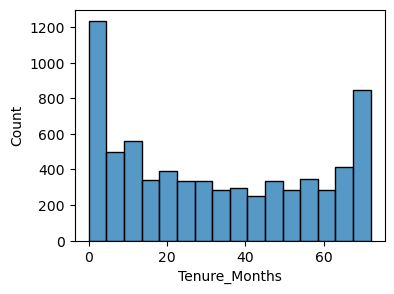

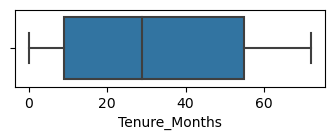

In [19]:
plt.figure(figsize=(4,3))
sns.histplot(x=df["Tenure_Months"]);

# Let's check for outliers with a box plot

plt.figure(figsize=(4,1))
sns.boxplot(x=df["Tenure_Months"]);

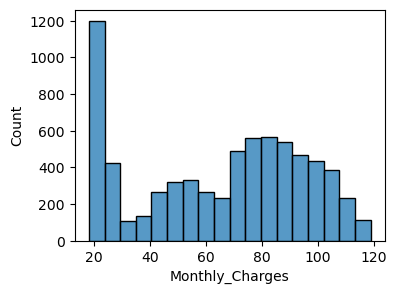

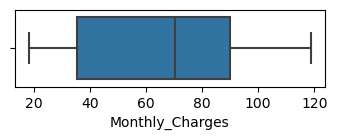

In [20]:
plt.figure(figsize=(4,3))
sns.histplot(x=df["Monthly_Charges"]);

# Let's check for outliers with a box plot

plt.figure(figsize=(4,1))
sns.boxplot(x=df["Monthly_Charges"]);

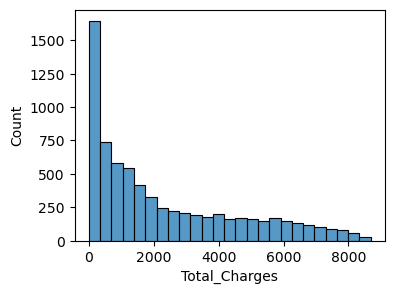

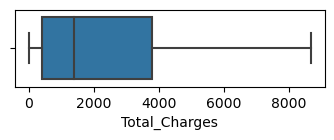

In [21]:
plt.figure(figsize=(4,3))
sns.histplot(x=df["Total_Charges"]);

# Let's check for outliers with a box plot

plt.figure(figsize=(4,1))
sns.boxplot(x=df["Total_Charges"]);

Clearly, this variable is right-skewed

### Feature Transformation

We will now attempt to apply power transformations to the numeric features to make them near normal distribution. By default PowerTransformer will apply 'yeo-johnson' transformation.

In [22]:
for col in ['Tenure_Months','Monthly_Charges','Total_Charges']:
    pt = PowerTransformer()
    trans = pt.fit_transform(pd.DataFrame(df[col]))
    df[col] = trans.reshape(-1,1)

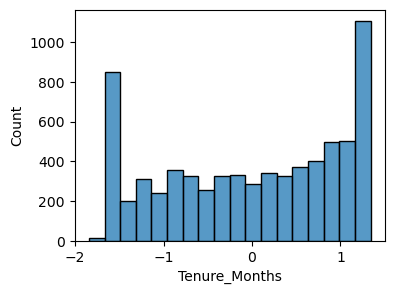

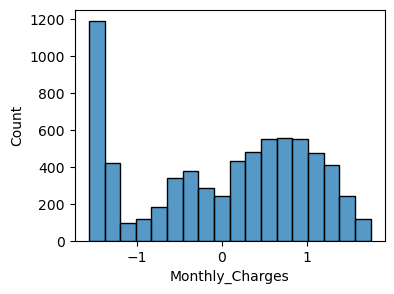

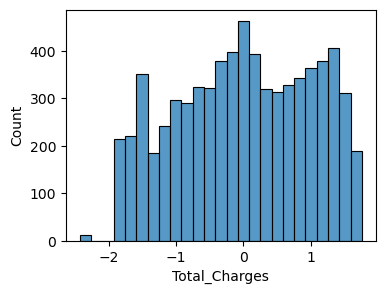

In [23]:
for col in ['Tenure_Months','Monthly_Charges','Total_Charges']:

    plt.figure(figsize=(4,3))
    sns.histplot(x=df[col]);

**Checking for Correlations amongst the numeric variables**

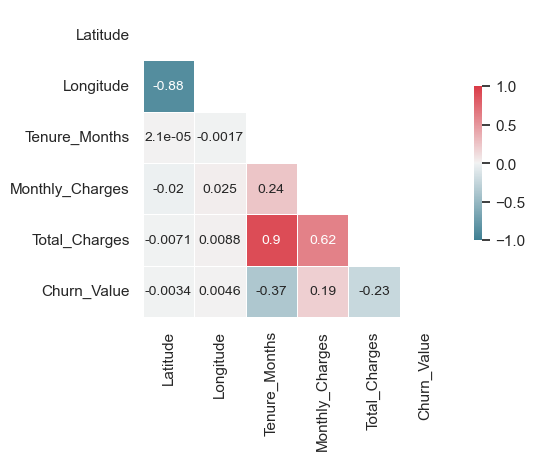

In [24]:
# Correlation matrix

sns.set(style="white", font_scale=1)
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(6, 4))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax=sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, center=0,
               square=True, linewidths=.5, cmap=cmap,
               cbar_kws={"shrink": .5}, annot=True, annot_kws={"size": 10})
cbar=ax.collections[0].colorbar
cbar.set_ticks([-1, -0.50, 0, 0.50, 1])

We will be dropping Longitude and Total_Charges since the correlation coefficients are very high.

In [25]:
df.drop(['Longitude','Total_Charges'], axis=1, inplace=True)

**One-Hot encoding**

Since XGBOOST does not support categorical variables we need to one-hot encode the categorical variables before giving them to XGBOOST

In [26]:
categorical_cols =['City', 'Gender', 'Senior_Citizen', 'Partner', 'Dependents', 'Phone_Service',
           'Multiple_Lines', 'Internet_Service', 'Online_Security', 'Online_Backup',
           'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies',
           'Contract', 'Paperless_Billing', 'Payment_Method']

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [27]:
df_encoded.head()

,Latitude,Tenure_Months,Monthly_Charges,Churn_Value,City_Acton,City_Adelanto,City_Adin,City_Agoura_Hills,City_Aguanga,City_Ahwahnee,...,Streaming_TV_No_internet_service,Streaming_TV_Yes,Streaming_Movies_No_internet_service,Streaming_Movies_Yes,Contract_One_year,Contract_Two_year,Paperless_Billing_Yes,Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,33.964131,-1.495444,-0.342665,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,34.059281,-1.495444,0.213545,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,34.048013,-0.926287,1.147891,1,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,1,0
3,34.062125,0.080538,1.311858,1,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,1,0
4,34.039224,0.761599,1.276886,1,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0


The number of variables has increased trastically after one-hot encoding. We will use dimentionality reduction technique later to reduce the number of dimentions.

### Splitting the data into Training & Test sets

In [28]:
y = df_encoded['Churn_Value']
X = df_encoded.drop('Churn_Value', axis=1, inplace=False)

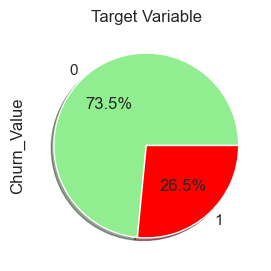

In [29]:
# Looking at the distribution of the target variable 'Churn_Value'

pd.value_counts(y).plot(kind='pie',
                        y='Attrition_Flag',
                        title='Target Variable',
                        colors = ['lightgreen', 'red'],
                        shadow=True,
                        figsize=(3,3),
                        autopct='%1.1f%%');

There is clearly a class imbalance problem with the target variable here which we have to address during modeling

In [30]:
# Splitting the data into 75:25 for Training & testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40, stratify=y)

In [31]:
# Checking data set dimensions

print(X_train.shape)
print(X_test.shape)

(5282, 1158)
(1761, 1158)


### Dimensionality reduction

We will be using Principal Component Analysis(PCA) for dimentionality reduction

In [32]:
# Using Principal Component Analysis

from sklearn.decomposition import PCA
from IPython.display import display

print(f"Actual number of components: {len(X_train.columns.values)}")

n_pc = len(X_train.columns.values)

pca = PCA(n_components=n_pc)
pca.fit(X_train)

cve = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_), 
                   index=range(1,n_pc+1), 
                   columns=['Cumulative Variance Explained'])

Actual number of components: 1158


Let's take a look at the cumulative variance explained by the first 50 Principal Components

In [33]:
display(cve.head(50))

,Cumulative Variance Explained
1,0.427466
2,0.608755
3,0.695374
4,0.729530
5,0.748594
6,0.766281
7,0.783797
8,0.800168
9,0.815356
10,0.829787


Text(0, 0.5, 'Variance Explained')

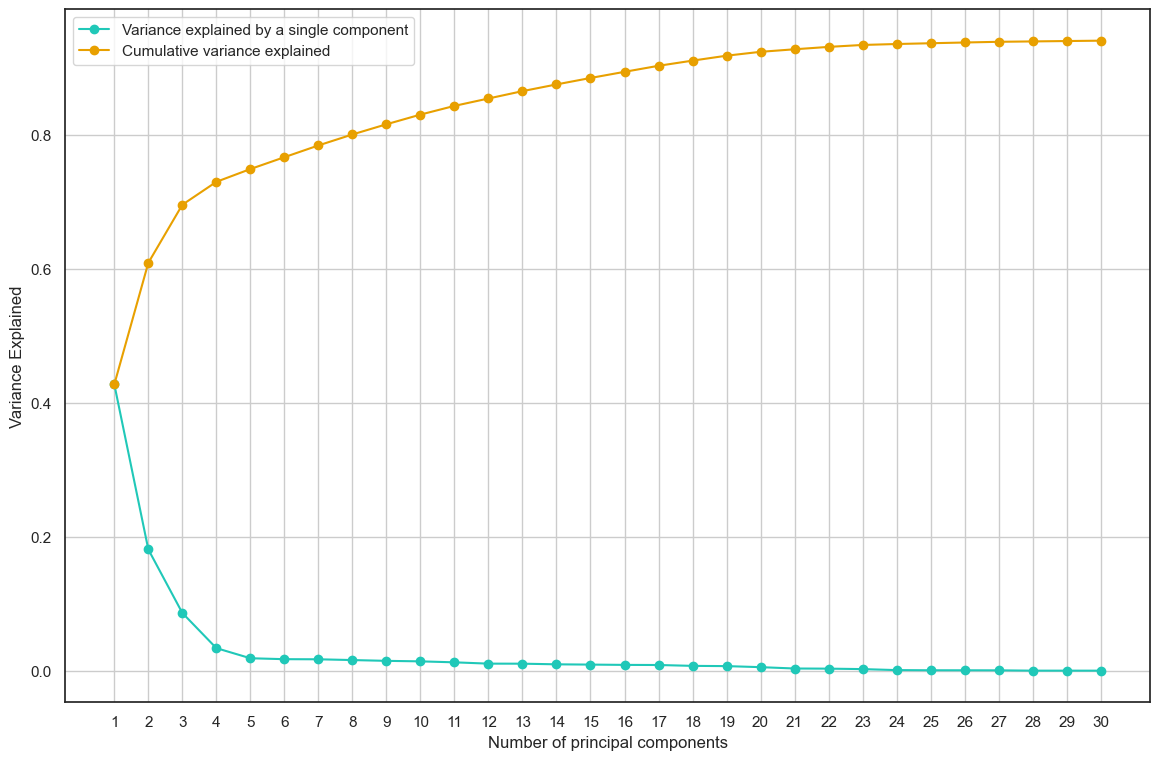

In [34]:
# Plotting on a graph

fig=plt.figure(1, figsize=(14,9))
plt.grid(visible=True, which='major', axis='both')
plt.plot(pca.explained_variance_ratio_[:30], marker='o', color='#20c8b8')
plt.plot(np.cumsum(pca.explained_variance_ratio_[:30]), marker='o', color='#e8a000')
n_pc = 30
plt.xticks([n for n in range(0,n_pc)], [ str(n) for n in range(1,n_pc+1)])
plt.legend(["Variance explained by a single component", "Cumulative variance explained"])
plt.xlabel('Number of principal components')
plt.ylabel('Variance Explained')

Clearly, till PC25 there is increase in cumulative variance explained, after that the graph plateaus and increases very slowly. So taking first 25 principal component captures **93.6%** of the variance explained. This is good because now using PCA we have come down drastically from 1158 to 25 dimentions.

In [35]:
n_pc = 25
pca = PCA(n_components=n_pc)
pca.fit(X_train)

X_25d_train= pd.DataFrame(pca.transform(X_train))
X_25d_test = pd.DataFrame(pca.transform(X_test))

X_25d_train.columns = ['PC' + str(i) for i in range(1, n_pc+1) ]
X_25d_test.columns = ['PC' + str(i) for i in range(1, n_pc+1) ]

# Just taking a look at the first 5 observations(transformed values) of the train data PCs
X_25d_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
0,-0.633130,-1.956039,1.137770,-0.071394,-0.088692,0.721865,-0.147009,0.357733,0.955269,0.507102,...,0.375241,-0.821597,-0.017992,0.202529,-0.012576,0.348318,0.133210,0.019811,-0.032753,-0.009095
1,2.229694,-2.118985,0.678803,-0.367717,-0.502113,0.065670,-0.652849,-0.151480,0.546372,0.859309,...,0.192874,-1.211021,-0.039436,0.537685,0.110310,-0.071779,-0.165833,-0.034280,0.024270,-0.000923
2,3.526953,-0.217847,-0.744038,-0.030686,0.127832,-0.634537,0.151255,-0.207807,-0.258511,0.092669,...,-0.108789,-0.259783,-0.630917,-0.345620,-0.551506,0.374942,0.264737,0.038824,0.042809,0.006248
3,-2.446565,0.083218,-2.199330,-0.349362,0.506687,-0.360536,0.423688,-0.204744,-0.199159,-0.021948,...,0.202923,0.375396,-0.064261,0.533894,-0.048803,0.103509,-0.291668,-0.039011,-0.051256,-0.003742
4,-1.930153,2.938884,0.285711,-0.238448,-0.228769,-0.134680,-0.917004,0.203396,0.841695,-0.188270,...,0.020386,0.012955,0.027240,-0.001293,0.066503,-0.057188,-0.186708,-0.067151,-0.056200,0.005501


In [36]:
X_train = X_25d_train
X_test = X_25d_test

print(X_train.shape)
print(X_test.shape)

(5282, 25)
(1761, 25)


### Using SMOTE technique to address the Target class imbalance problem

SMOTE stands for Synthetic Minority Oversampling Technique. SMOTE is an improved method of dealing with imbalanced data in classification problems. It is an algorithm that performs data augmentation by creating synthetic data points based on the original data points. SMOTE can be seen as an advanced version of oversampling, or as a specific algorithm for data augmentation. The advantage of SMOTE is that we are not generating duplicates, but rather creating synthetic data points that are slightly different from the original data points.

In [37]:
smote = SMOTE()
X_train_balance, y_train_balance = smote.fit_resample(X_train, y_train)

In [38]:
# Let's check out the target variable class distribution now

pd.DataFrame(data=list(y_train_balance), columns=['Target']).value_counts()

Target
0         3880
1         3880
dtype: int64

### Model building

We shall first build an XGBOOST classifier for this task. XGBOOST is well known to perform extremely well on tabular data. Later on we shall try one more classification algorithm and then compare the two.

In [39]:
# We shall use Grid Search Cross-validation to find out optimal hyperparameters for XGBOOST classifier

parameter_grid = {
        'objective': ['binary:logistic'],            
        'max_depth': [5,10],
        'subsample': [0.3,0.6,1],
        'colsample_bytree': [0.1,0.5,1],
        'min_child_weight': [1,2,3],
        'n_estimators': [50,100,200],
        'learning_rate': [0.1,0.2],
        'n_jobs': [-1]
}

clf_name = 'xgbclassifier__'
classifier = xgboost.XGBClassifier()

new_params = {clf_name + key: parameter_grid[key] for key in parameter_grid}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40) # 5-fold Cross Validation
imba_pipeline = make_pipeline(classifier)
SCORE = 'accuracy' 
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring=SCORE, return_train_score=True)
grid_imba.fit(X_train_balance, y_train_balance)

print(f"Best configuration found for {classifier}:")
print("\n", grid_imba.best_params_)

Best configuration found for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...):

 {'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 10, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__n_jobs': -1, 'xgbclassifier

Test F1 score:  0.71
Test ROC_AUC score:  0.72

Test set:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83      1294
           1       0.54      0.62      0.58       467

    accuracy                           0.76      1761
   macro avg       0.70      0.72      0.71      1761
weighted avg       0.77      0.76      0.77      1761

Confusion Matrix:
 [[1048  246]
 [ 176  291]]


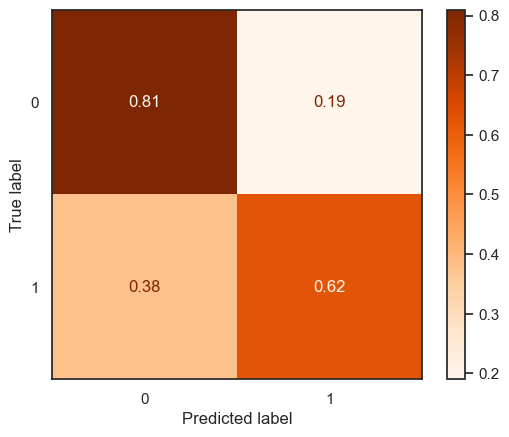

In [40]:
classifier.fit(X_train_balance, y_train_balance)
y_pred_test = classifier.predict(X_test)

# Checking for test set

xgb_f1 = round(f1_score(y_test, y_pred_test, average='macro'),2)
xgb_auc = round(roc_auc_score(y_test, y_pred_test, average='macro'),2)
print("Test F1 score: ", xgb_f1)
print("Test ROC_AUC score: ", xgb_auc)
print("\nTest set:\n", classification_report(y_test, y_pred_test))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Oranges', normalize='true');

We shall try one more classification algorithm for this problem

### Weighted Neural Network

Typically, careful attention is required when defining the costs or “weightings” to use for cost-sensitive learning. However, for imbalanced classification where only misclassification is the focus, the weighting can use the inverse of the class distribution observed in the training dataset.

The Tensorflow Keras deep learning library provides support for class weighting. The fit() function that is used to train Keras neural network models takes an argument called 'class_weight'. This argument allows us to define a dictionary that maps class integer values to the weights to apply to each class.

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from numpy.random import seed
seed(40)
tf.keras.utils.set_random_seed(40)

# defining the neural network model

n_input = X_train.shape[1]

model = Sequential([
    Dense(32, input_dim=n_input, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')    
], name="Weighted_Neural_Network")

adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam)
model.summary()

Model: "Weighted_Neural_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                832       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,921
Trainable params: 1,921
Non-trainable params: 0
_________________________________________________________________


The above model configuration was determined after trying out multiple iterations with different model configurations such as increasing the number of layers, increasing/decreasing number of neurons in each layer, etc. 

In [42]:
# Wighted Neural Network

weights = {0:1, 1:3}
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="auto",
    restore_best_weights=True
)

# Train the model
history = model.fit(X_train, y_train, class_weight=weights, validation_split=0.2,
                    epochs=100, callbacks=[es], verbose=1)

# Predict using the trained model
yhat = model.predict(X_test)

Epoch 1/100
133/133 [==============================] - 1s 3ms/step - loss: 0.8958 - val_loss: 0.5166
Epoch 2/100
133/133 [==============================] - 0s 2ms/step - loss: 0.7516 - val_loss: 0.4839
Epoch 3/100
133/133 [==============================] - 0s 3ms/step - loss: 0.7215 - val_loss: 0.5184
Epoch 4/100
133/133 [==============================] - 0s 2ms/step - loss: 0.7059 - val_loss: 0.4692
Epoch 5/100
133/133 [==============================] - 0s 2ms/step - loss: 0.6955 - val_loss: 0.4665
Epoch 6/100
133/133 [==============================] - 0s 2ms/step - loss: 0.6901 - val_loss: 0.4748
Epoch 7/100
133/133 [==============================] - 0s 2ms/step - loss: 0.6844 - val_loss: 0.4643
Epoch 8/100
133/133 [==============================] - 0s 2ms/step - loss: 0.6797 - val_loss: 0.4407
Epoch 9/100
133/133 [==============================] - 0s 2ms/step - loss: 0.6760 - val_loss: 0.4548
Epoch 10/100
133/133 [==============================] - 0s 3ms/step - loss: 0.6719 - val_lo

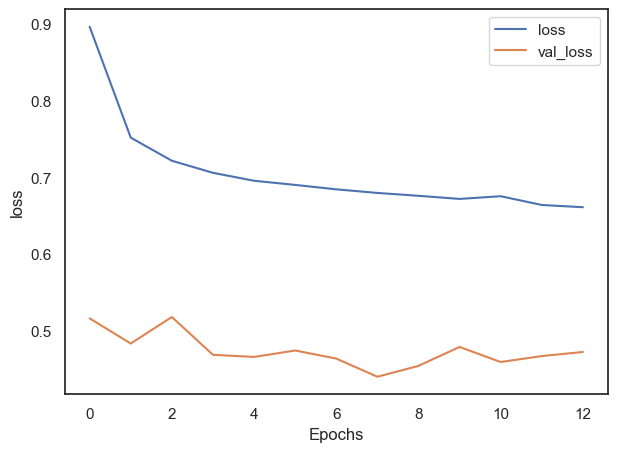

Test F1 score:  0.73
Test AUC_ROC score:  0.77

               precision    recall  f1-score   support

           0       0.91      0.74      0.82      1294
           1       0.53      0.80      0.64       467

    accuracy                           0.76      1761
   macro avg       0.72      0.77      0.73      1761
weighted avg       0.81      0.76      0.77      1761



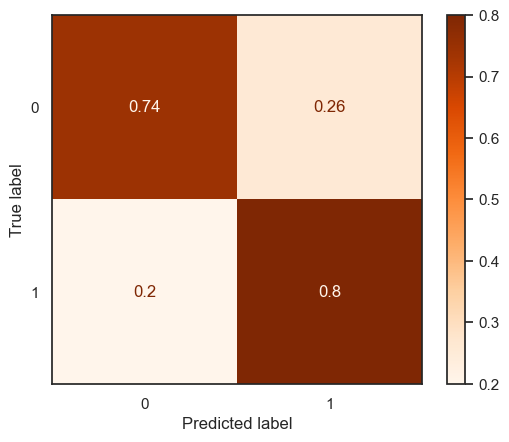

In [44]:
def plot_graphs(history, metric):
    
    plt.figure(figsize=(7,5))
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "loss")

nn_cm = confusion_matrix(y_test, np.around(yhat))
nn_f1 = round(f1_score(y_test, np.around(yhat), average='macro'),2)
nn_auc = round(roc_auc_score(y_test, np.around(yhat), average='macro'),2)
print("Test F1 score: ", nn_f1)
print("Test AUC_ROC score: ", nn_auc)
print("\n", classification_report(y_test, np.around(yhat)))
ConfusionMatrixDisplay.from_predictions(y_test, np.around(yhat), cmap='Oranges', normalize='true');

### Final Observations

In [46]:
pd.DataFrame([[xgb_f1, nn_f1],[xgb_auc, nn_auc]], 
             index = ['F1_Score','AUC_ROC'],
             columns = ['XGBOOST','Weighted Neural Network'])

,XGBOOST,Weighted Neural Network
F1_Score,0.71,0.73
AUC_ROC,0.72,0.77


The Weighted Neural Network (WNN) has performed way better than the XGBOOST model in terms of classifying the minority class (Customers that are likely to churn) although with some sacrifice in performance of the majority class classification. The overall F1 score of the WNN is also slightly better than XGBOOST classifier but the Area Under the ROC curve is much better.